In [1]:
%matplotlib inline
import sys
sys.path.append('sample4Acause/')
from forwardmodels import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm, multivariate_normal

Assume that we have some density estimator $K(y)$ from $Y$

Sample random $x^t$, set $t=1$ and run the loop:
1. Evaluate $y^t$ = $RTM(x^t)$
2. Estimate density $p_y^t = K(y^t)$
3. Sample new $x^t$ using $p_y^t$ and set $t = t + 1$

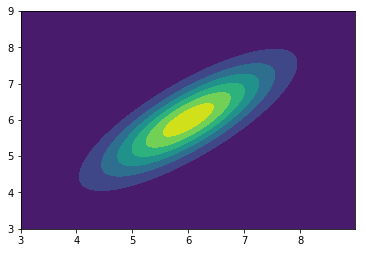

In [2]:
x1, x2 = np.mgrid[3:9:.01, 3:9:.01]; pos = np.dstack((x1, x2))
rv = multivariate_normal([6, 6], [[1.0, 0.8], [0.8, 1.0]])
fig2 = plt.figure(); ax2 = fig2.add_subplot(111)
ax2.contourf(x1, x2, rv.pdf(pos))

In [106]:
def directexp(x):
    return(np.square(x))
    #return(np.sin(x))

Text(0.5,1,'C transformed to E')

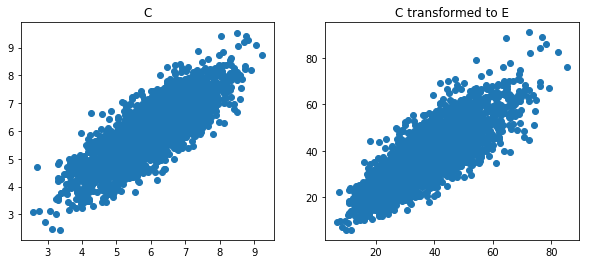

In [107]:
fig,ax = plt.subplots(1,2,figsize=[10,4])
X_true = rv.rvs(3000); Y = directexp(X_true)
ax[0].scatter(X_true[:,0],X_true[:,1]); ax[0].set_title('C')
ax[1].scatter(Y[:,0],Y[:,1]); ax[1].set_title('C transformed to E')

In [108]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian').fit(Y)

In [109]:
mini = -50
maks = 150
deli = 5
grid = int((maks-mini)/deli)
y1, y2 = np.mgrid[mini:maks:deli, mini:maks:deli]; pos = np.dstack((y1, y2))

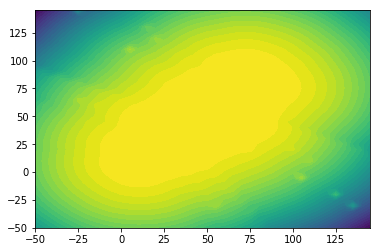

In [110]:
plt.contourf(y1, y2, kde.score_samples(pos.reshape(grid**2,2)).reshape(grid,grid),40)

In [111]:
'''ABC rejection sampling'''
N = 5000
k = 10
order = 2
ABCsamples = []
for i in range(N):
    epsilon = 3#0.05
    x_ = np.random.uniform(low = 1, high = 10, size=(1,2))
    #epsilon = epsilon + epsilon*np.exp(np.abs(np.linalg.norm(x_))) # growing epsilon with scale
    y_ = directexp(x_)
    dists = np.linalg.norm(Y-y_,ord=order,axis=1)
    smallest = np.argpartition(dists,k)[:k]
    dist = np.mean( dists[smallest] )
    if dist <= epsilon:
        ABCsamples.append(x_)
ABCsamples = np.array(ABCsamples).reshape(-1,2)

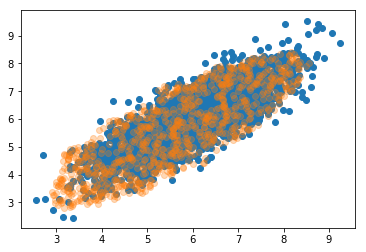

In [112]:
plt.scatter(X_true[:,0],X_true[:,1])
plt.scatter(ABCsamples[:,0],ABCsamples[:,1],alpha=0.3)

In [113]:
'''ABC rejection sampling /w KDE'''
N = 5000
k = 10
order = 2
ABCsamples = []
epsilon = 100000
for i in range(N):
    x_ = np.random.uniform(low = 1, high = 10, size=(1,2))
    y_ = directexp(x_)
    py = np.exp(kde.score(y_))
#    print(py)
    if np.random.uniform() <= py*epsilon:
        ABCsamples.append(x_)
ABCsamples = np.array(ABCsamples).reshape(-1,2)

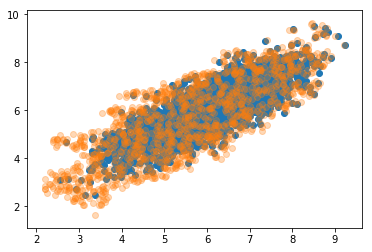

In [114]:
plt.scatter(X_true[:,0],X_true[:,1])
plt.scatter(ABCsamples[:,0],ABCsamples[:,1],alpha=0.3)

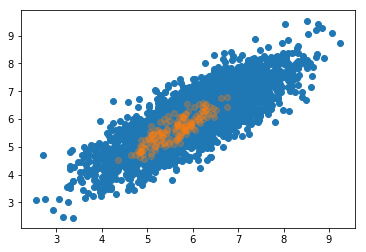

In [120]:
'''Moving Mercadona sampling /w KDE''' # Pertubate samples w/ white noise, accept a proportion of jump based KDE
N = 150
T = 300
X_ = np.random.uniform(low = 1, high = 10, size=(N,2))

for t in range(T):
    pertubator = np.random.normal(loc=0.,scale=2,size=[N,2])
    X_hold = X_
    X_ = X_ + pertubator
    Y_ = directexp(X_)
    py = np.exp(kde.score_samples(Y_))
    X_ = X_hold + pertubator * (py.reshape(N,1)/py.max())
    
plt.scatter(X_true[:,0],X_true[:,1])
plt.scatter(X_[:,0],X_[:,1],alpha=0.3)

# Conclusion: Just makes all the points converge to the center

In [116]:
# Idé : Farv hvert X mhb. på density estimate i transformerede domæne

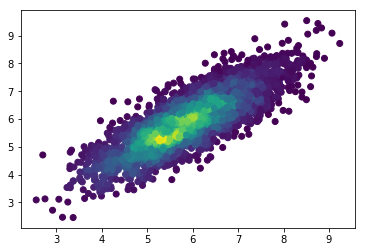

In [123]:
Y_true = directexp(X_true)
dens_kde = np.exp(kde.score_samples(Y_true))
dens_true = rv.pdf(X_true)
plt.scatter(X_true[:,0],X_true[:,1],c=dens_kde)

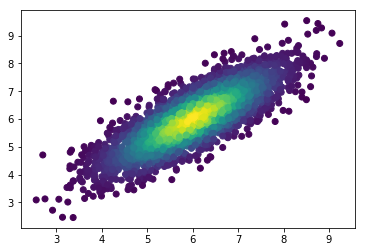

In [124]:
plt.scatter(X_true[:,0],X_true[:,1],c=dens_true)

In [ ]:
# Idé : Vurder vigtighed i hver iteration af de N punkter, sample N nye punkter ved at sample fra de N gamle med replacement 

In [ ]:
a = np.array([2,1,51313,123,1])
p = np.array([0,0.2,0.6,0.1,0.1])

In [ ]:
np.random.choice(a,size=a.shape[0],p=p)